## Analysis for Supplementary Information

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
from itertools import groupby
from scipy.stats import ks_2samp
from matplotlib.colors import LogNorm
from sklearn.metrics import r2_score
from functools import reduce
from sklearn.metrics import roc_curve, recall_score, confusion_matrix, roc_auc_score

### Fig. S1

from https://www.science.org/lookup/doi/10.1126/science.aan0693 download and unzip the following folders in aan0693_si_datasets.tar.gz.zip :

design_structural_metrics.tar.gz
design_scripts.tgz
stability_scores.tar.gz

In [5]:
### previous published data

def import_rd3_rd4_data(rd3_rd4_metrics, rd3scores, rd4scores):
    ''' returns dataframe with designs' metrics and stabilityscore data '''
    metrics=pd.read_csv(rd3_rd4_metrics)
    scores3=pd.read_csv(rd3scores, delim_whitespace=True)
    scores4=pd.read_csv(rd4scores, delim_whitespace=True)
    scores=pd.concat([scores3, scores4])
    
    df=pd.merge(left=metrics, right=scores, on='name', how='inner')
    df.rename(columns={'sequence_x':'sequence'}, inplace=True)
    return(df)

rd3_rd4=import_rd3_rd4_data('../data/design_structural_metrics/rd3_rd4_metrics.csv', 
                            'datasets/rd3_stability_scores', 
                            'datasets/rd4_stability_scores')


FileNotFoundError: [Errno 2] No such file or directory: '../data/design_structural_metrics/rd3_rd4_metrics.csv'

In [6]:
def import_bp_files():
    ''' returns a df with abego and corresponding bp file number '''
    abego_list=[]
    file_num=[]
    for i in range(27):
        with open('aan0693_SI_datasets/design_scripts/rd3/heeh_'+str(i)+'.bp') as x:
            bp_file=[]
            bp_file=x.readlines()
        abego_seq= ''
        for j in range(3, 44):
            # get abego seq (w/o first and last abego seq)
            abego_seq += bp_file[j][9]
        abego_list.append(abego_seq)
        file_num.append(i)
    bp_df=pd.DataFrame(abego_list, columns=['abego'])
    bp_df['bp_file']=file_num
    return bp_df

rd3_rd4_bp = import_bp_files()

FileNotFoundError: [Errno 2] No such file or directory: 'aan0693_SI_datasets/design_scripts/rd3/heeh_0.bp'

In [3]:
rd3_rd4_bp

NameError: name 'rd3_rd4_bp' is not defined

In [4]:
def merge_data():
    ''' combine dataframes from import_bp_files() and import_rd3_rd4_data() '''
    df=pd.merge(left=rd3_rd4, right=rd3_rd4_bp, on='abego', how='outer')
    df['stable'] = [score for score in df['stabilityscore']>=0.8]
    df=df.drop_duplicates(subset=['name'])
    return df[df['bp_file'] >= 0]

In [5]:
def success_rate_bpfile():
    ''' returns df with success rate for each bp file '''
    df=merge_data()
    # identify unique abego sequences
    unique_abegos = df['abego'].unique()   
    success_rate = []
    for i in range(len(unique_abegos)):
        stable=len(df[ (df['stable']==True) & (df['abego']==unique_abegos[i])])
        total=len(df[ df['abego'] == unique_abegos[i]])
        success_rate.append([unique_abegos[i], stable, total, stable/total, i if total>0 else 0])
    # create new df with abego and abego success
    success_df = pd.DataFrame(success_rate, columns = ['abego', 'stable_designs', 'total_designs', 'success_rate', 'bp_file']).sort_values('success_rate', ascending = False)
    return success_df

bp_success = success_rate_bpfile()

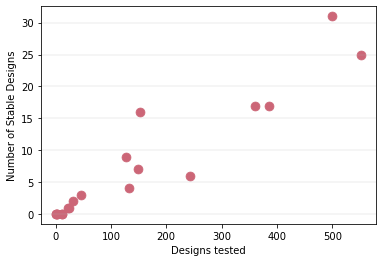

In [6]:
def plot_stable_vs_n_designs():
    ''' returns scatter plot stable_designs vs total_designs '''
    plt.grid(axis='y', linewidth=0.25)
    sns.scatterplot(x='total_designs', 
                    y='stable_designs', 
                    data=bp_success, 
                    s=80, 
                    color=['#CC6677'], 
                    edgecolor=None)
    plt.xlabel('Designs tested')
    plt.ylabel('Number of Stable Designs')
    #plt.savefig('FigS1a.svg')
plot_stable_vs_n_designs()

In [7]:
def scatterplots(feature, threshold_line):
    trend=np.polyfit(rd3_rd4[feature], rd3_rd4['stabilityscore'], 1)
    trend_line=np.poly1d(trend)
    plt.plot(rd3_rd4[feature], trend_line(rd3_rd4[feature]), color='#CC6677')
    sns.scatterplot(x=feature, 
                    y='stabilityscore', 
                    data=rd3_rd4, 
                    color='#CC6677', 
                    alpha=0.2, 
                    edgecolor=None)
    plt.axvline(threshold_line, color = 'gray')
    plt.xlabel(feature)
    #plt.xticks([115, 120, 125, 130, 135])
    plt.ylabel('Stability Score')
    #plt.savefig('FigS1b_1.tiff', dpi=300)

    #scatterplot_buried_np_per_res()

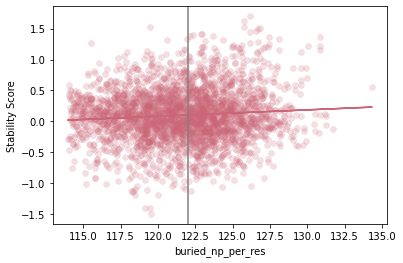

In [8]:
scatterplots(feature='buried_np_per_res', threshold_line=122)

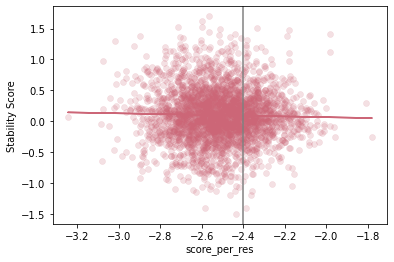

In [9]:
scatterplots(feature='score_per_res', threshold_line=-2.4)

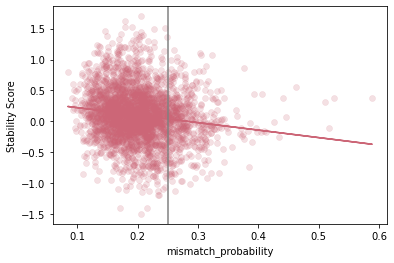

In [10]:
scatterplots(feature='mismatch_probability', threshold_line=0.25)

In [6]:
rd5_metrics=pd.read_csv('../data/design_structural_metrics/rd5_metrics.csv')

/Users/tek317/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (329,908,1566) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


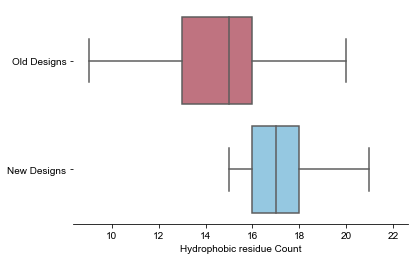

In [12]:
def boxplot_nhphob():
    percent_hphob=pd.concat([ rd3_rd4['n_hydrophobic'], rd5_metrics['n_hydrophobic'] ], axis = 0)
    df=pd.DataFrame(percent_hphob)
    df['type']=['Old Designs'] * len(rd3_rd4) + ['New Designs'] * len(rd5_metrics)
    color=['#CC6677', '#88CCEE']
    plot=sns.boxplot(x='n_hydrophobic', y='type', data=df, fliersize=0, palette=color)
    sns.despine(left=True), sns.set_style('ticks')
    plt.xlabel('Hydrophobic residue Count'), plt.ylabel('')
    #plt.savefig('FigS2c_1.svg')
boxplot_nhphob()

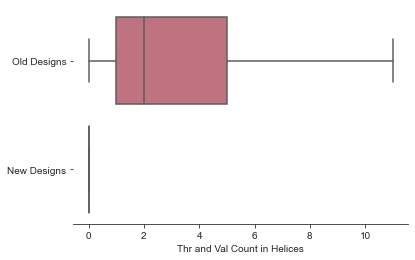

In [19]:
def boxplot_TV_helix():
    # create df with helices_freq_T_V
    all_TV_counts=[]
    datasets=[rd3_rd4, rd5_metrics]
    for dataset in datasets:
        for dssp, seq in zip(dataset['dssp'], dataset['sequence']):
            h1_start=dssp.find('H')
            h1_end=dssp.find('HL')
            h2_start=dssp.find('LH', 20)
            h2_end=dssp.find('HL', 30)

            seq_h1=seq[h1_start: h1_end + 1]
            seq_h2=seq[h2_start: h2_end + 1]

            count=0
            for residue in seq_h1:
                if residue in 'TV': count +=1
            for residue in seq_h2:
                if residue in 'TV': count +=1
            all_TV_counts.append(count)

    df = pd.DataFrame(all_TV_counts, columns=['TV_counts'])
    df['type']=['Old Designs'] * len(rd3_rd4) + ['New Designs'] * len(rd5_metrics)

    old_designs_max_TV=df.query('type == "Old Designs"')['TV_counts'].max()
    old_designs_min_TV=df.query('type == "Old Designs"')['TV_counts'].min()
    new_designs_max_TV=df.query('type == "New Designs"')['TV_counts'].max()
    new_designs_min_TV=df.query('type == "New Designs"')['TV_counts'].min()

    diff_old_designs=old_designs_max_TV - old_designs_min_TV
    diff_new_designs=new_designs_max_TV - new_designs_min_TV

    color=['#CC6677', '#88CCEE']
    plot=sns.boxplot(x='TV_counts', y='type', data=df, fliersize=0, palette=color)
    sns.despine(left=True), sns.set_style('ticks')
    plt.xlabel('Thr and Val Count in Helices'), plt.ylabel('')
    #plt.savefig('FigS2c_2.svg')
boxplot_TV_helix()

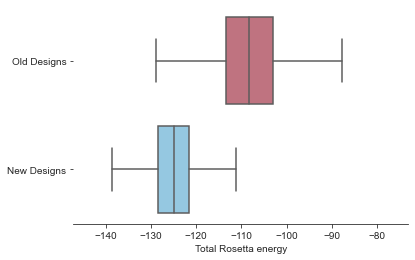

In [20]:
def boxplot_score():
    score=pd.concat([ rd3_rd4['total_score'], rd5_metrics['total_score'] ], axis = 0)
    df=pd.DataFrame(score)
    df['type']=['Old Designs'] * len(rd3_rd4) + ['New Designs'] * len(rd5_metrics)

    color=['#CC6677', '#88CCEE']
    plot=sns.boxplot(x='total_score', y='type', data=df, fliersize=0, palette=color)
    sns.despine(left=True), sns.set_style('ticks')
    plt.xlabel('Total Rosetta energy'), plt.ylabel('')
    #plt.savefig('FigS2C_3.svg')
boxplot_score()

### Fig S2

In [4]:
def import_rd5_rd5_dms_rd6_scores(rd5, rd5_dms, rd6):
    rd5_scores=pd.read_csv(rd5)
    rd5_dms_scores=pd.read_csv(rd5_dms)
    rd6_scores=pd.read_csv(rd6)
    rd6_scores=rd6_scores [ ~rd6_scores['name'].str.contains('ladder|pdb')] 
    rd6_scores = rd6_scores [ ~rd6_scores['name'].str.contains('PG_hp')] # keep design scores
    return(rd5_scores.query('cat=="design"'), rd5_dms_scores, rd6_scores)

rd5_scores, rd5_dms_scores, rd6_scores = import_rd5_rd5_dms_rd6_scores(rd5='../data/stability_scores/rd5_stability_scores.csv',
                                                               rd5_dms='../data/stability_scores/rd5_deep_mutational_scanning_stability_scores.csv',
                                                               rd6='../data/stability_scores/rd6_stability_scores.csv')

In [29]:
def plot_ec50(x_var, y_var, stability_scores, filelabel):
    print('n_designs: ', len(stability_scores))
    print('r2: ', r2_score(stability_scores[x_var], stability_scores[y_var]))    
    min_xval = min(stability_scores[x_var])
    min_yval = min(stability_scores[y_var])
    max_xval = max(stability_scores[x_var])
    max_yval = max(stability_scores[y_var])
    
    plt.hist2d(x=x_var, y=y_var, data=stability_scores, bins=100, norm=LogNorm(), cmap ="Blues"),
    plt.colorbar()
    if x_var=='ec50_c':
        plt.xticks([0, max_xval/6, max_xval/6*2, max_xval/6*3, max_xval/6*4, max_xval/6*5, max_xval/6*6])
        plt.yticks([0, max_yval/6, max_yval/6*2, max_yval/6*3, max_yval/6*4, max_yval/6*5, max_yval/6*6])
     
    plt.xlabel(x_var), plt.ylabel(y_var)
    #plt.savefig(filelabel + x_var + '.tiff', dpi=300)

n_designs:  5618
r2:  0.6565634289164046


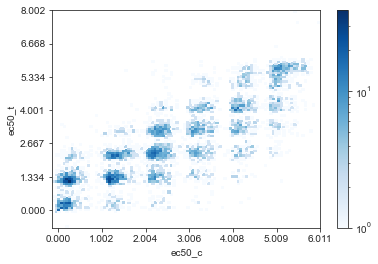

In [25]:
# ec50 values relabeled in concentration (nM) 
# ec50: nM
# 0:0, 1:28, 2:83, 3:250, 4:750, 5:2250, 6:6750

plot_ec50(x_var='ec50_c', y_var='ec50_t', stability_scores=rd5_scores, filelabel='rd5')

n_designs:  5618
r2:  0.6626816386414811


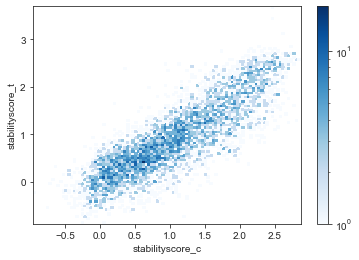

In [26]:
plot_ec50(x_var='stabilityscore_c', y_var='stabilityscore_t', stability_scores=rd5_scores, filelabel='rd5')

n_designs:  7416
r2:  0.5558563136290378


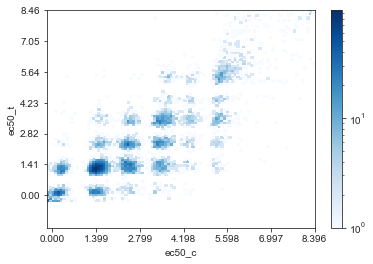

In [27]:
plot_ec50(x_var='ec50_c', y_var='ec50_t', stability_scores=rd6_scores, filelabel='rd6')

n_designs:  7416
r2:  0.4442997337565322


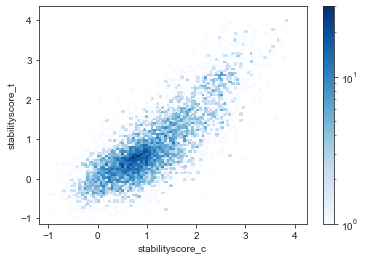

In [28]:
plot_ec50(x_var='stabilityscore_c', y_var='stabilityscore_t', stability_scores=rd6_scores, filelabel='rd6')

In [75]:
#dms_scores=pd.read_csv('../data/stability_scores/rd5_deep_mutational_scanning_stability_scores.csv')
#dms_scores['num'] = [int(name.split('_')[3][:4]) for name in dms_scores['name']]

n_designs:  4650
r2:  0.08983931605813067


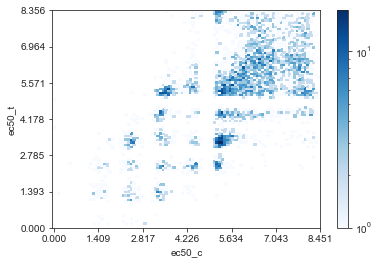

In [33]:
plot_ec50(x_var='ec50_c', y_var='ec50_t', stability_scores=rd5_dms_scores, filelabel='rd5_dms')

n_designs:  4650
r2:  -0.013312945244111196


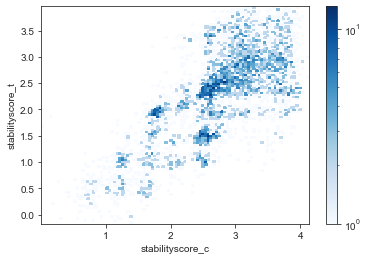

In [34]:
plot_ec50(x_var='stabilityscore_c', y_var='stabilityscore_t', stability_scores=rd5_dms_scores, filelabel='rd5_dms')

### FigS3


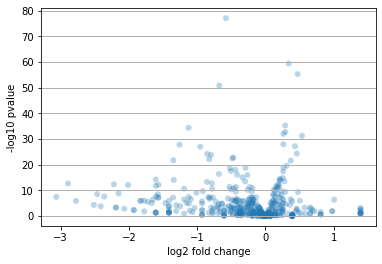

In [24]:
def volcano_plot(df):
    # make dict of aa seq
    aa_list = ['A','F','I','L','M','V','W','Y','G','P','Q','N','C','S','T','H','R','K','D','E']
    # make sub-df separating ss >= 1.0 and ss < 1.0
    s = df.query('stabilityscore > 1.0')
    no = df.query('stabilityscore <= 1.0')
    # make lists of sequences
    seq_s = list(s['sequence'])
    seq_no = list(no['sequence'])
    # create empty list with each element being a position's dictionary { aa : frequency}
    pos_s = []
    pos_no = []
    for i in range(43):
        pos_s.append(dict.fromkeys(aa_list, 0)) # create keys
        pos_no.append(dict.fromkeys(aa_list, 0))
    # populate empty list with aa frequencies
    for seq in seq_s: # for each design
        for i in range(43): # go through each position of the design
            aa = seq[i] # id the aa at each position
            pos_s[i][aa] +=1 # add the aa to the position list
    for seq in seq_no:
        for i in range(43):
            aa = seq[i]
            pos_no[i][aa] +=1
    to_add = []
    for position in range(len(pos_s)): # go through each position down the heatmap
        for residue in range(len(aa_list)): # go through each aa on the heatmap for a specific position (ie look at each square)
            name = aa_list[residue] + str(position+1) # create a name for each 'square' on the heatmap
            k = pos_s[position].get(aa_list[residue]) # get the number of success for each pos_aa
            k_no = pos_no[position].get(aa_list[residue]) # get the number of no success for each pos_aa
            k_total = k + k_no
            array = (k, k_no)
            if k_total == 0:
                pass
            else:
                obs_ss = k/(k_total) # probability of observed success rate = ( # of ss designs with aa X / total # designs with aa X )
                theor_ss = len(s)/len(df) # probability of theoretical success 2157/5799
                ''' fc is based on overall theoretical success '''
                fc = obs_ss/theor_ss
                try:
                    log2fc = math.log2(fc)
                    pv = stats.binom_test(x = array, p = theor_ss) # binomial test
                    log10pv = math.log(pv) * -1
                    row = [name, k, k_total, obs_ss, theor_ss, pv, log10pv, fc, log2fc]
                    to_add.append(row) # append list
                except ValueError:
                    pass
    # create df
    binom_df = pd.DataFrame(to_add, columns =[ 'name', 'k', 'total', 'obs_ss', 'theor_ss', 'pv', 'log10pv', 'fc', 'log2fc'])
    # plot
    plt.scatter(x = binom_df['log2fc'], y = binom_df['log10pv'], alpha = 0.3, edgecolors = 'none' ), plt.grid(axis = 'y', linewidth = 1)
    plt.xlabel('log2 fold change')
    plt.ylabel('-log10 pvalue')
    return binom_df
    #plt.savefig('FigS5a.svg')

binom_df = volcano_plot(df=rd5_scores)

In [27]:
binom_df.query('name=="L2"')

,name,k,total,obs_ss,theor_ss,pv,log10pv,fc,log2fc
13,L2,630,1194,0.527638,0.380562,9.462320e-25,55.31731,1.386469,0.471416


In [26]:
binom_df.query('name=="E2"')

,name,k,total,obs_ss,theor_ss,pv,log10pv,fc,log2fc
25,E2,534,2096,0.254771,0.380562,3.244155e-34,77.111038,0.669459,-0.578932


### Fig S4

In [185]:
wts=['HEEH_TK_rd5_0018','HEEH_TK_rd5_0341','HEEH_TK_rd5_0420','HEEH_TK_rd5_0614','HEEH_TK_rd5_0958','HEEH_TK_rd5_3711']

def cat(x):
    for i in wts:
        if i in x:
            return i
    if 'PG_hp' in x:
        return 'PG_hp'
    else:
        return 'design'
rd5_dms_scores['cat'] = [cat(x) for x in rd5_dms_scores['name'].values]

In [53]:
aas='QENHDRKTSAGMLVIWYFP'

def makessm(c="HEEH_TK_rd5_0018.pdb",value='stabilityscore',center=1,annot=True):
    wtseq = rd5_dms_scores.query('name == "%s.pdb"' % c)['protein_sequence_c'].values[0]
    wt=rd5_dms_scores.query('name == "%s.pdb"' % c)[value].values[0]
    
    out=np.zeros((43,19))
    out[:] = wt
    
    subdf=rd5_dms_scores.query('cat == "%s"' % c)
    for name, v in zip(subdf['name'], subdf[value]):
        if name.count('_') == 4:
            pos = int(name.split('_')[-1][1:-1])
            aa = name[-1]
            out[pos-1, aas.index(aa)] = v
    
    plt.figure(figsize=(20,7))
    
    if annot:
        annotation = np.where(out > 1, out, '').T
    else:
        annotation=False
    
    if center=='wt': center=wt
    
    hm = sns.heatmap(out.T, xticklabels=['%s%s' % (aa, pos) for aa, pos in zip(wtseq, range(1,44))], yticklabels=[x for x in aas],
               cmap='RdBu',center=center,annot=annotation,fmt='.3s')
    plt.plot([0,43],[5,5],color='black')
    plt.plot([0,43],[7,7],color='black')
    plt.plot([0,43],[11,11],color='black')
    plt.plot([0,43],[15,15],color='black')
    plt.plot([0,43],[18,18],color='black')
    
    
    
    for i in range(43):
        plt.scatter(i+0.5,aas.index(wtseq[i])+0.5, s=30,color='black')
        
    cax = plt.gcf().axes[-1]
    cax.plot([0,2],[wt,wt],color='black',linewidth=3)    
    return hm


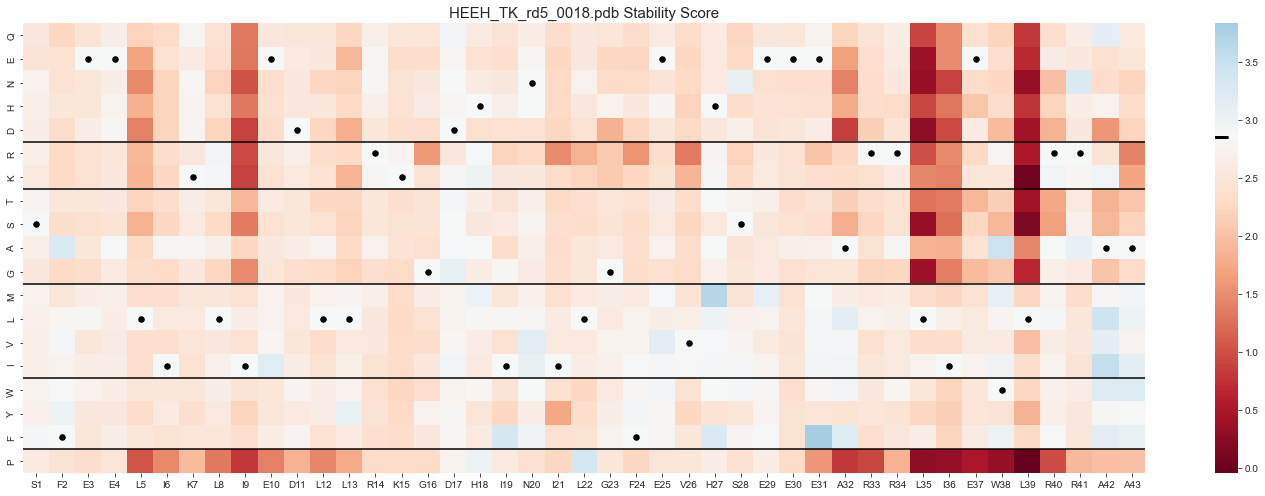

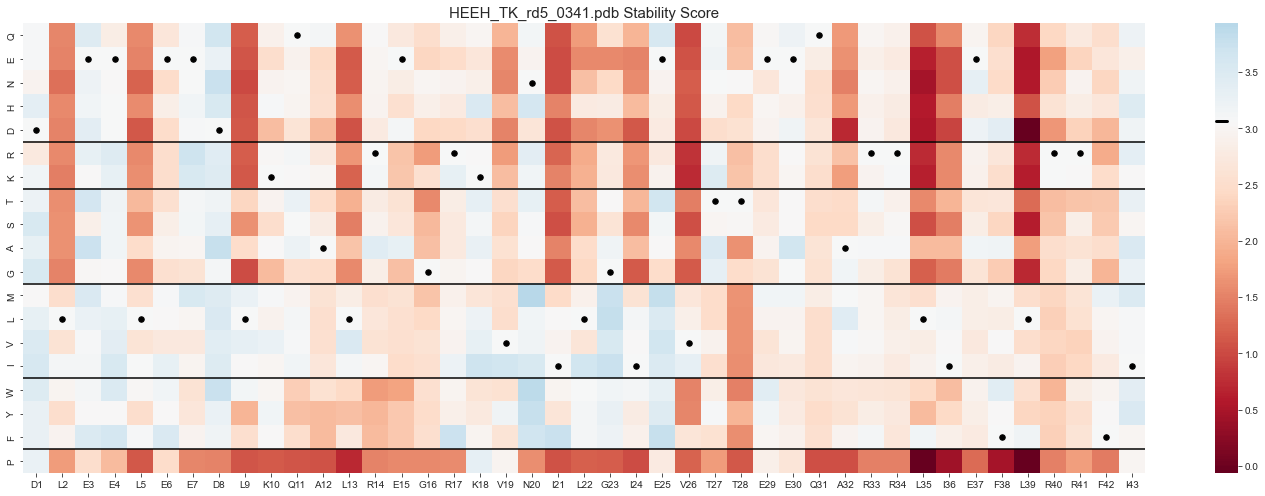

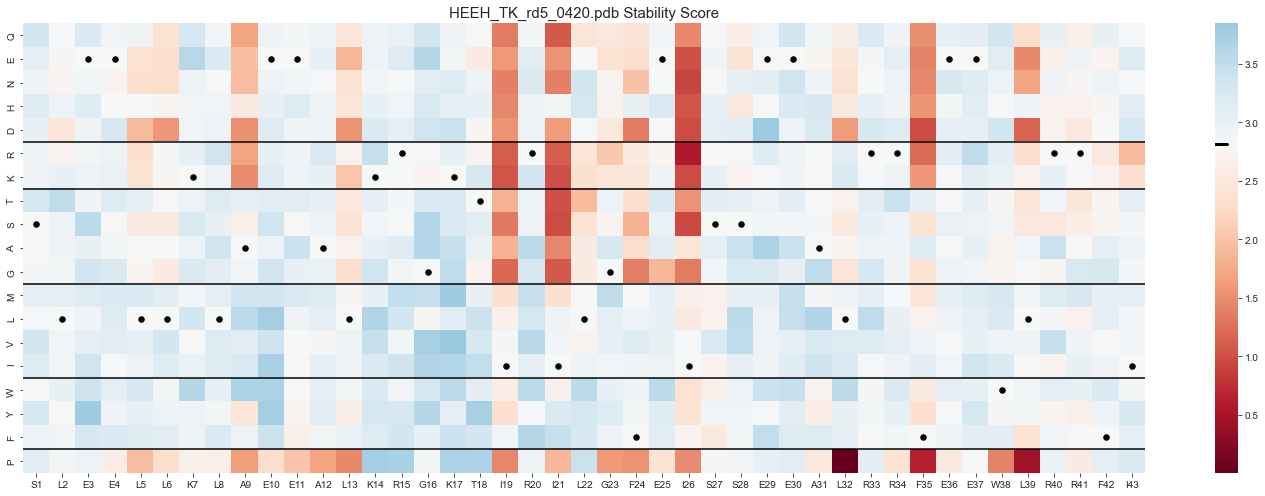

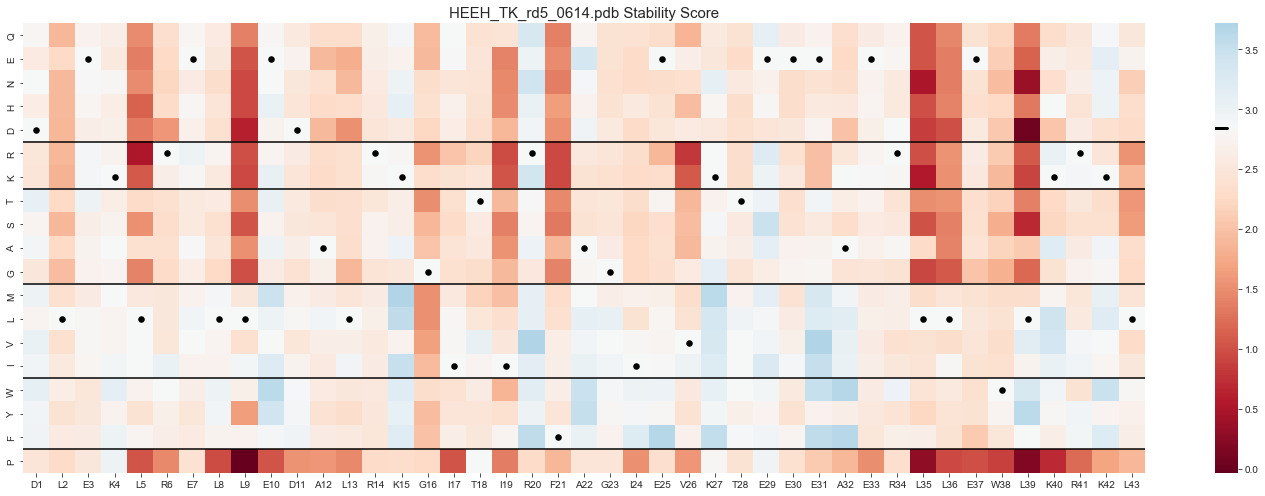

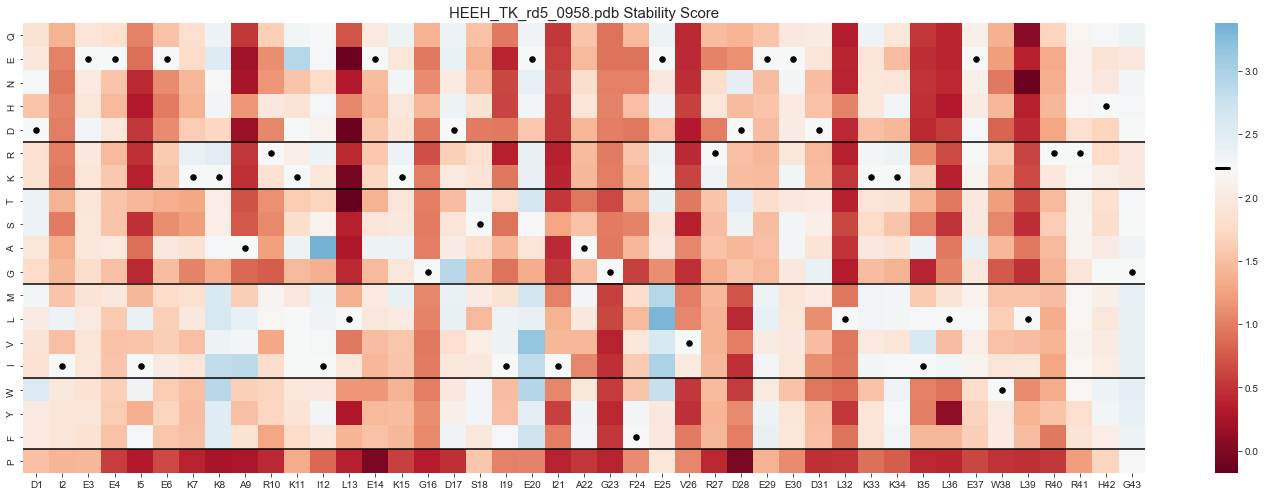

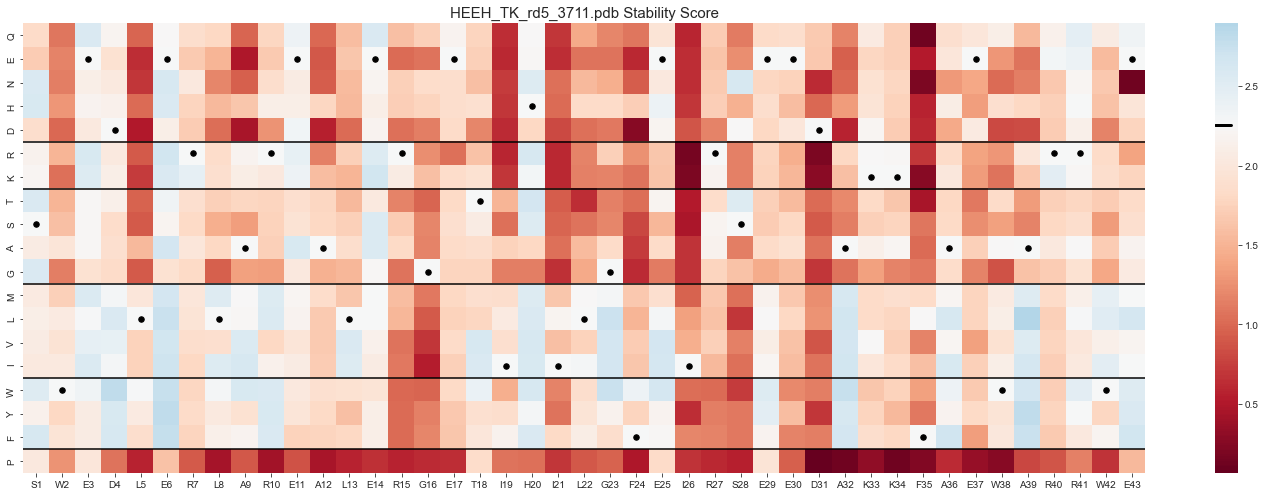

In [54]:
for wt in ['HEEH_TK_rd5_0018','HEEH_TK_rd5_0341','HEEH_TK_rd5_0420','HEEH_TK_rd5_0614','HEEH_TK_rd5_0958','HEEH_TK_rd5_3711']:
    out = makessm(wt, annot=False, center='wt')
    plt.title('%s.pdb Stability Score' % wt,fontsize=15)
    plt.tight_layout()
    #plt.savefig('%s.svg' % wt)

### Fig S6

In [292]:
rd5_dms_af=pd.read_csv('../data/design_structural_metrics/rd5_deep_mutational_scanning_alphafold_rmsd.csv')


rd5_dms_af['lowest_pred_rmsd'] =rd5_dms_af[['pred_rmsd_model_1', 
                             'pred_rmsd_model_2', 
                             'pred_rmsd_model_3', 
                             'pred_rmsd_model_4', 
                             'pred_rmsd_model_5']].min(axis=1)


rd5_dms_scores=pd.read_csv('../data/stability_scores/rd5_deep_mutational_scanning_stability_scores.csv')


rd5_dms_scores['rename']=[name[:16]+'_'+name.split('_')[-1]+'.pdb' for name in rd5_dms_scores['name']]
#rd5_dms_scores['cat'] = rd5_dms_scores['cat']+'.pdb'
rd5_dms_wt=pd.merge(left=rd5_dms_af, right=rd5_dms_scores[['name', 'stabilityscore']], left_on='design', right_on='name', how='inner')
rd5_dms=pd.merge(left=rd5_dms_af, right=rd5_dms_scores[['rename', 'stabilityscore']], left_on='design', right_on='rename', how='inner')

#rd5_dms['lowest_pred_rmsd'] =dms[['pred_rmsd_model_1', 
#                             'pred_rmsd_model_2', 
#                             'pred_rmsd_model_3', 
#                             'pred_rmsd_model_4', 
#                             'pred_rmsd_model_5']].min(axis=1)

rd5_dms['wt'] = [int(design[12:16]) for design in rd5_dms['design']]



HEEH_TK_rd5_0018.pdb 2.857318118 774
HEEH_TK_rd5_0341.pdb 3.060434599 774
HEEH_TK_rd5_0420.pdb 2.811398536 774
HEEH_TK_rd5_0614.pdb 2.84452684 774
HEEH_TK_rd5_0958.pdb 2.228895039 774
HEEH_TK_rd5_3711.pdb 2.256549549 774


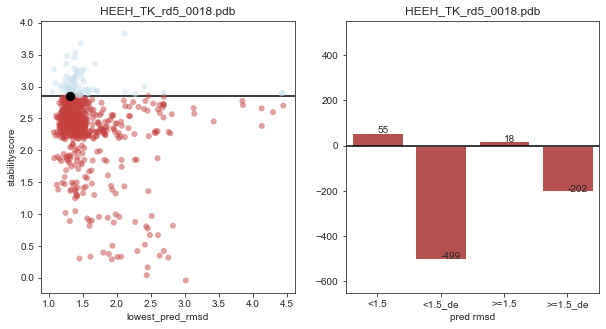

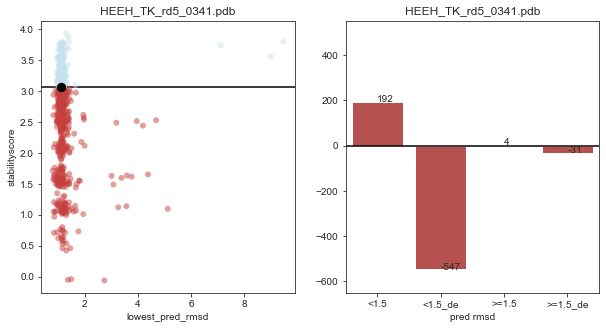

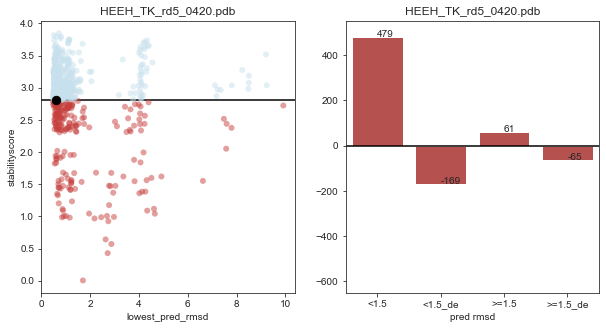

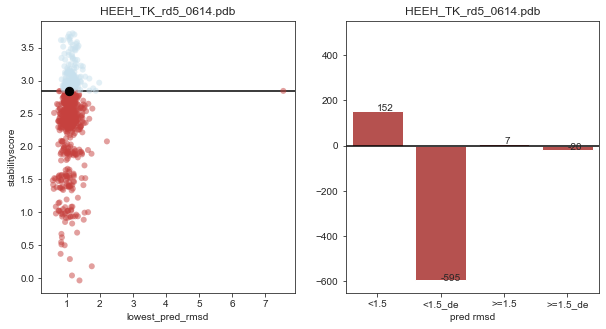

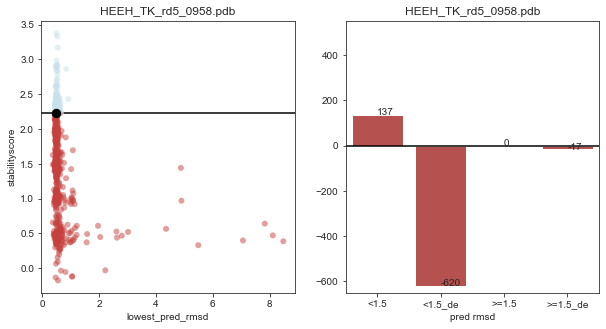

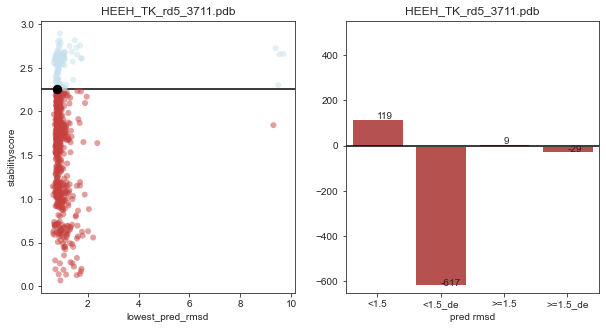

In [295]:
def dms_scatterplots():
    
    all_designs = np.unique(rd5_dms_wt['design'])
    wts = [18, 341, 420, 614, 958, 3711]
    
    for design, wt in zip(all_designs, wts):

        wt_stabilityscore = float(rd5_dms_wt.query('design==@design')['stabilityscore'])
        wt_rmsd = float(rd5_dms_wt.query('design==@design')['lowest_pred_rmsd'])
        print(design, wt_stabilityscore, len(rd5_dms.query('wt==@wt')))
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        dmsplot1 = sns.scatterplot(x='lowest_pred_rmsd', y='stabilityscore', 
                                  data=rd5_dms.query('wt==@wt & stabilityscore <= @wt_stabilityscore'), 
                                  zorder=3,
                                  alpha=0.5,
                                  edgecolor='none',
                                  color='#C6413E')
        dmsplot2 = sns.scatterplot(x='lowest_pred_rmsd', y='stabilityscore', 
                                  data=rd5_dms.query('wt==@wt & stabilityscore > @wt_stabilityscore'), 
                                  zorder=3,
                                  alpha=0.5,
                                  edgecolor='none',
                                  color='#C7E0ED')
        plt.scatter(x=wt_rmsd, y=wt_stabilityscore, s=70, color='black', zorder=4)
        plt.axhline(y=float(wt_stabilityscore), color='black')
       
        plt.title(design)


        plt.subplot(1, 2, 2)    
        less_s = len(rd5_dms.query('wt==@wt & lowest_pred_rmsd <1.5 & stabilityscore > @wt_stabilityscore'))#/n_designs
        less_de = len(rd5_dms.query('wt==@wt & lowest_pred_rmsd <1.5 & stabilityscore <= @wt_stabilityscore'))#/n_designs

        more_s = len(rd5_dms.query('wt==@wt & lowest_pred_rmsd >=1.5 & stabilityscore > @wt_stabilityscore'))#/n_designs
        more_de = len(rd5_dms.query('wt==@wt & lowest_pred_rmsd >=1.5 & stabilityscore <= @wt_stabilityscore'))#/n_designs

        less_de = -less_de
        more_de = -more_de
        stabilizing_greaterthan_two = len(rd5_dms.query('wt==@wt & lowest_pred_rmsd >=1.5 & stabilityscore > @wt_stabilityscore'))#/n_designs

        destabilizing_lessthan = len(rd5_dms.query('wt==@wt & lowest_pred_rmsd <1.5 & stabilityscore <= @wt_stabilityscore'))#/n_designs
        destabilizing_greaterthan_two = len(rd5_dms.query('wt==@wt & lowest_pred_rmsd >=1.5 & stabilityscore <= @wt_stabilityscore'))#/n_designs

        destabilizing_lessthan = -destabilizing_lessthan
        destabilizing_greaterthan_two = -destabilizing_greaterthan_two

        x = ['<1.5', '<1.5_de', '>=1.5', '>=1.5_de']
        y = [less_s, less_de, more_s, more_de]
        sns.barplot(x=x, y=y, color='#C6413E')
        plt.axhline(y=0, color='black')
        plt.xlabel('pred rmsd')
        plt.ylim(-650, 550)
        plt.title(design)

        for i in range(len(x)):
            plt.text(i,y[i],y[i])

        plt.savefig(design[:16]+'_af_dms_rmsd_plot.svg')
        
dms_scatterplots()

### Fig S7

In [106]:
def load_weights_data():
     # load default weight
    weight1 = []
    with open('../data/design_scripts/rd6_designs/beta_nov16.wts', 'r') as file:
        for line in file:
            weight1.append(line.rstrip())
        weight1 = weight1[3:-2]
    # load rd6 weights
    rd6_weight_files = ['weight_B.wts', 'weight_C.wts', 'weight_D.wts']
    weight2, weight3, weight4 = [], [], []
    rd6_weights = [weight2, weight3, weight4]
    for weight_file, weight in zip(rd6_weight_files, rd6_weights):
        with open('../data/design_scripts/rd6_designs/'+weight_file, 'r') as file:
            for line in file:
                weight.append(line.rstrip())

    weight2, weight3, weight4 = weight2[3:-2], weight3[3:-2], weight4[3:-2]

    weights1_df = pd.DataFrame()
    weights1_df['feat'] = [ weight.split(' ')[0] for weight in weight1]
    weights1_df['weight1'] = [ float(weight.split(' ')[1]) for weight in weight1]

    rd6_weights_df = pd.DataFrame()
    rd6_weights_df['feat'] = [ weight.split(' ')[0] for weight in weight2]
    rd6_weights_df['weight2'] = [ float(weight.split(' ')[1]) for weight in weight2]
    rd6_weights_df['weight3'] = [ float(weight.split(' ')[1]) for weight in weight3]
    rd6_weights_df['weight4'] = [ float(weight.split(' ')[1]) for weight in weight4]

    weights_df = pd.merge(left=weights1_df, right=rd6_weights_df, on='feat', how='inner')
    return weights_df
weights_df = load_weights_data()

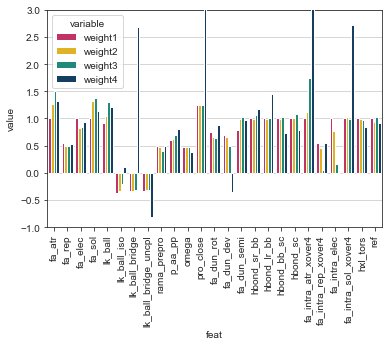

In [108]:
def plot_weights():
    df = pd.melt(weights_df, id_vars=['feat'], value_vars=['weight1', 'weight2', 'weight3', 'weight4'])
    order = ['fa_atr', 'fa_rep', 'fa_elec', 'fa_sol',
            'lk_ball', 'lk_ball_iso', 'lk_ball_bridge', 'lk_ball_bridge_uncpl',
            'rama_prepro', 'p_aa_pp', 'omega', 'pro_close',
            'fa_dun_rot', 'fa_dun_dev', 'fa_dun_semi',
            'hbond_sr_bb', 'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc',
            'fa_intra_atr_xover4', 'fa_intra_rep_xover4', 'fa_intra_elec', 'fa_intra_sol_xover4',
            'hxl_tors', 'ref']
    colors = ['#D81B60', '#FFC107', '#0E9C84', '#0A3F6D']
    plt.grid(axis='y', zorder=-1)
    plt.ylim([-1, 3])
    sns.barplot(x='feat', y='value', data=df.query('feat != "dslf_fa13"'), hue='variable', order=order, palette=colors, zorder=10),
    plt.xticks(rotation=90)
   # plt.savefig('FigS6.svg')
plot_weights()

### Fig S8

In [2]:
def load_data(metrics, scores):
    metrics = pd.read_csv(metrics)
    scores = pd.read_csv(scores)
    scores = scores [ ~scores['name'].str.contains('ladder')] #remove rows with 'ladders'
    scores_design = scores [ ~scores['name'].str.contains('PG_hp')] #design scores
    scores_scr = scores [ scores['name'].str.contains('PG_hp')] #scrambled scores
    scores_scr['name2'] = [name[:16] for name in scores_scr['name'] ]
    designs = pd.merge(left=metrics, right=scores_design, on='name', how='inner')
    return designs, scores_scr 

rd6, rd6_scr = load_data(metrics='../data/design_structural_metrics/rd6_metrics.csv',
                         scores='../data/stability_scores/rd6_stability_scores.csv')

/Users/tek317/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (908) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-2-b351b6585a29>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores_scr['name2'] = [name[:16] for name in scores_scr['name'] ]


In [30]:
rd6

,name,oldname,AlaCount,T1_absq,T1_netq,Tend_absq,Tend_netq,Tminus1_absq,Tminus1_netq,abego_res_profile,...,dna_sequence_c,protein_sequence_c,full_protein_sequence_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore,psipred,n_psipred_H,n_hydrophobic_y
0,HEEH_KT_rd6_0001,selected1_01protocol_00_0005_0001_fragments_lo...,2,5.0,-5.0,9.0,7.0,4.0,2.0,0.238999,...,GACTTCGAGGAGGTTCGTAAAATCCTGGAAGAAGCGAAACGTAAAA...,DFEEVRKILEEAKRKNTSVKIGDIEVHSEEEAKELLKRELEKI,GGGSASHMDFEEVRKILEEAKRKNTSVKIGDIEVHSEEEAKELLKR...,1.504104,-1.257029,-0.599755,-0.599755,CHHHHHHHHHHHHHCCCCCEECCEEECCHHHHHHHHHHHHHCC,26.0,14
1,HEEH_KT_rd6_0002,selected1_01protocol_00_0007_0001_fragments_lo...,4,4.0,-4.0,7.0,5.0,3.0,1.0,0.227396,...,TCTGCGGAAGAAGAGGAAAAAGCGCTCCGTGAAGCGCTGGAACGTA...,SAEEEEKALREALERNVSYRLGDKTVTEEELWRRALEWIKKVV,GGGSASHMSAEEEEKALREALERNVSYRLGDKTVTEEELWRRALEW...,-0.110801,0.286734,0.136807,0.002086,CHHHHHHHHHHHHHHHCHHHCCCCCCCHHHHHHHHHHHHHHHC,33.0,17
2,HEEH_KT_rd6_0003,selected1_01protocol_00_0007_0002_fragments_lo...,3,5.0,-5.0,7.5,5.5,2.5,0.5,0.190235,...,ACCATCGAAGAAATCGAACACGAAATCCGTGAAGCGATCGAACGTC...,TIEEIEHEIREAIERRTSIINGDLTANREEEFKRLIEWARHVD,GGGSASHMTIEEIEHEIREAIERRTSIINGDLTANREEEFKRLIEW...,0.622167,0.821642,0.392023,-0.286311,CHHHHHHHHHHHHHHHHHHHCCCCCCCCHHHHHHHHHHHHCCC,31.0,15
3,HEEH_KT_rd6_0004,selected1_01protocol_00_0014_0002_fragments_lo...,4,5.0,-5.0,9.0,5.0,4.0,0.0,0.247004,...,ACCGAGGAAGAAATCAAACGTCTGCTGATCGAACTGGCGGAACGCC...,TEEEIKRLLIELAERREEHKDGDIIIKDEEAAKRALEELERRK,GGGSASHMTEEEIKRLLIELAERREEHKDGDIIIKDEEAAKRALEE...,1.227306,3.914699,1.867786,0.916280,CHHHHHHHHHHHHHHHHHCCCCCEEECCHHHHHHHHHHHHHCC,30.0,14
4,HEEH_KT_rd6_0005,selected1_01protocol_00_0017_0002_fragments_lo...,3,4.5,-3.5,9.5,8.5,5.0,5.0,0.273322,...,TCTGAAGAAGAGGCTAAACGCCTGATCGAAGAAGCGCGTCGTCGTG...,SEEEAKRLIEEARRRGTILELGDVRFTDEHAEEKWREILKRLK,GGGSASHMSEEEAKRLIEEARRRGTILELGDVRFTDEHAEEKWREI...,0.520307,3.040265,1.450575,0.727417,CHHHHHHHHHHHHHHCCCEEECCCCCCHHHHHHHHHHHHHHHC,29.0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6996,HEEH_KT_rd6_7412,selected4_08protocol_25_0276_0002_fragments_lo...,6,3.0,-3.0,5.0,3.0,2.0,0.0,0.205758,...,GCGGAATGGGCGTGGGAATTCACCCGTGAAGCGCTGCGTCGTGGTA...,AEWAWEFTREALRRGITTVEIAGLEVRITSEEAARHVIELWLR,GGGSASHMAEWAWEFTREALRRGITTVEIAGLEVRITSEEAARHVI...,0.268321,2.316465,1.105235,0.543595,CCCHHHHHHHHHHCCCCEEEECCEEEEECCHHHHHHHHHHHHC,22.0,21
6997,HEEH_KT_rd6_7413,selected4_08protocol_25_0282_0001_fragments_lo...,2,3.0,-3.0,6.0,4.0,3.0,1.0,0.132408,...,GACGAATTCATCGAACACCTGATCCGTCACCTGTTCCGTCGTGGTA...,DEFIEHLIRHLFRRGIERGRVAGIEIHATGEELWWERLHRIER,GGGSASHMDEFIEHLIRHLFRRGIERGRVAGIEIHATGEELWWERL...,-0.219308,1.611022,0.768653,0.608392,CHHHHHHHHHHHHHCHHHCCCCEEEEEECCHHHHHHHHHHHCC,27.0,17
6998,HEEH_KT_rd6_7414,selected4_08protocol_25_0282_0002_fragments_lo...,2,4.0,-4.0,7.0,7.0,3.0,3.0,0.092137,...,TGGGAAGAACTGCGTTGGATTCTGGAACACCTGTTTCGTCGTCGTA...,WEELRWILEHLFRRRITEAHVLNVELWWTSEEIFEEALHRIRR,GGGSASHMWEELRWILEHLFRRRITEAHVLNVELWWTSEEIFEEAL...,-0.424080,1.660210,0.792121,0.588606,CHHHHHHHHHHHHHCCCHHHHHCEEEEECHHHHHHHHHHHHHC,31.0,20
6999,HEEH_KT_rd6_7415,selected4_08protocol_25_0289_0001_fragments_lo...,5,5.0,-5.0,7.0,7.0,2.0,2.0,0.159824,...,ACCGAAGAAGAGGAGGAAATCCTGCACCACGTTCGTCGTCGTAACC...,TEEEEEILHHVRRRNLTIFRAWGTTVRATSEEAALHAWQWWWR,GGGSASHMTEEEEEILHHVRRRNLTIFRAWGTTVRATSEEAALHAW...,-0.223987,2.059018,0.982401,0.596091,CHHHHHHHHHHHHCCCEEEECCCCEEEECHHHHHHHHHHHHCC,24.0,18


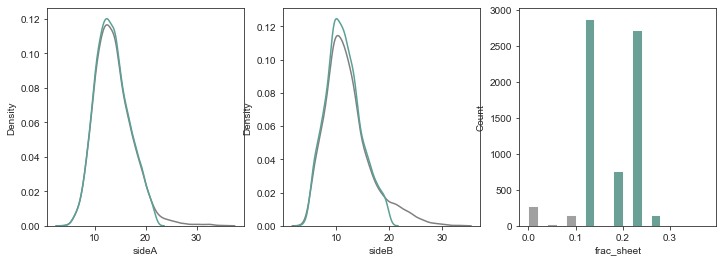

In [323]:
def plot_distance_and_strand():
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.kdeplot(rd6['sideA'],  color='gray')
    sns.kdeplot(rd6.query('sideA < 22')['sideA'], color='#5AA095')
    plt.subplot(1, 3, 2)
    sns.kdeplot(rd6['sideB'],  color='gray')
    sns.kdeplot(rd6.query('sideB < 20')['sideB'], color='#5AA095')
    plt.subplot(1, 3, 3)
    sns.histplot(rd6['frac_sheet'], bins=np.arange(0, 0.4, 0.02), color='gray')
    sns.histplot(rd6.query('frac_sheet > 0.117')['frac_sheet'], bins=np.arange(0, 0.4, 0.02), color='#5AA095')
    #plt.savefig('FigS7a.svg')
plot_distance_and_strand()

In [31]:
def filter1():
    ''' filter out designs whose helices are too far from hairpin, dssp is not HEEH, and len_loop >= 5  '''
    filter_metrics=rd6.query('sideB < 20 & sideA < 22 & frac_sheet > 0.117') # remove helices too far from hairpin
    
    designs_to_keep=[]
    for name, dssp in zip(filter_metrics['name'], filter_metrics['dssp']):
        topology_structure=[ list(g) for k, g in groupby(dssp)] # list of the how many elements constitute helices, strands, and loops
        topology_string = ''
        for i in range(len(topology_structure)):
            topology_string += topology_structure[i][0]
        # keep only desings with the structure L H L E L E L H L
        # keep designs whose loops are <5 residues long
        if topology_string == 'LHLELELHL':
            if len(topology_structure[2])<5 and len(topology_structure[4])<5 and len(topology_structure[6])<5 :
                designs_to_keep.append(name)
    designs_keep_df=pd.DataFrame(designs_to_keep, columns=['name'])
    filtered_df = pd.merge(left=filter_metrics, right=designs_keep_df, on='name', how='inner')   
    ''' filter out 95ci ''' 
    filtered_df=filtered_df.query('ec50_95ci_c <= 2 & ec50_95ci_t <= 2')
    
    filtered_scr = pd.merge(left=rd6_scr, right=filtered_df['name'], left_on='name2', right_on='name', how='inner')
    filtered_scr.rename(columns={'name_x':'name'}, inplace=True)
    filtered_scr.drop(['name2', 'name_y'], axis=1, inplace=True)
    return filtered_df, filtered_scr

filtered_designs1, filtered_scr1 = filter1()

In [32]:
len(filtered_designs1)

5320

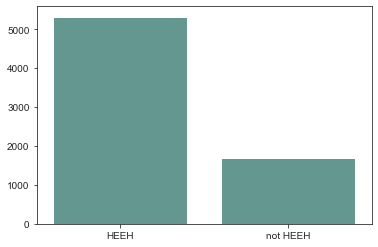

In [325]:
def plot_heeh_filter():
    all_names = list(rd6['name'])
    filtered_names = list(filtered_designs1['name'])
    notfiltered_names = list(set(all_names) - set(filtered_names))

    sns.barplot(x=['HEEH', 'not HEEH'], y=[len(filtered_names),len(notfiltered_names)], color='#5AA095')
    #plt.savefig('FigS7b.svg')
plot_heeh_filter()

In [326]:
def filter2():
    ''' keep designs by n_hphob, H number '''
    filtered_scr2 = filtered_scr1.query('n_hydrophobic < 18 | (n_hydrophobic < 22 & n_psipred_H < 30)')
    filtered_designs2 = filtered_designs1.query('n_hydrophobic_x < 18 | (n_hydrophobic_x < 22 & n_psipred_H < 30)')
    filtered=pd.concat([filtered_designs2, filtered_scr2])
    return filtered_designs2, filtered_scr2, filtered

filtered_designs2, filtered_scr2, filtered = filter2()

In [732]:
#filtered_designs2.to_csv('../data/design_structural_metrics/rd6_metrics_filtered.csv', index=False, header=True)
#filtered_scr2.to_csv('../data/stability_scores/rd6_scrambled_filtered.csv', index=False, header=True)

In [327]:
filtered_rd6=filtered_designs2

In [8]:
def prep_heatmap(design, scrambled):
    ''' keep only ‘n_hydrophobic < 18 | (n_hydrophobic < 22 & n_psipred_H < 30)'''
    stable_ratio_design = []
    stable_ratio_scr = []
    summary = []
    for H_number in np.arange(18,42,2):
        for nonpo in np.arange(14,24,2):
            sub_scr=scrambled.query('n_psipred_H >= %s & n_psipred_H < %s & n_hydrophobic >= %s & n_hydrophobic < %s' % (H_number, H_number+2, nonpo, nonpo+2))
            sub_designs=design.query('n_psipred_H >= %s & n_psipred_H < %s & n_hydrophobic_x >= %s & n_hydrophobic_x < %s' % (H_number, H_number+2, nonpo, nonpo+2))
            try:
                stable_ratio_design.append(len(sub_designs.query('stabilityscore>=1'))/len(sub_designs))
            except:
                stable_ratio_design.append(0)
            try:
                stable_ratio_scr.append(len(sub_scr.query('stabilityscore>=1'))/len(sub_scr))
            except:
                stable_ratio_scr.append(0)
            summary.append((H_number, nonpo))
    #summary_df = pd.DataFrame(summary, columns = ['len_helices', 'n_hphob'] )
    return summary, stable_ratio_design, stable_ratio_scr

summary, stable_ratio_design, stable_ratio_scr = prep_heatmap(design=filtered_designs1, 
                                                                      scrambled=filtered_scr1)

In [9]:
def heatmap(term, df):
    df = pd.DataFrame(summary, columns = ['len_helices', 'n_hphob'] )

    if term == 'design':
        df['design'] = stable_ratio_design
    elif term == 'scr':
        df['scr'] = stable_ratio_scr
    elif term == 'ratio':
        df['ratio'] = [(x-y)/y if y!=0 else 0 for (x,y) in zip(stable_ratio_design, stable_ratio_scr)]
    df = pd.pivot_table(df, index='len_helices', columns='n_hphob')

    sns.set(rc={'figure.figsize':(4,8)},style='white')
    
    if term=='design' or term=='scr':
        sns.heatmap(df, cmap='BrBG', center=0, vmin=0, vmax=1)
    elif term=='ratio':
        sns.heatmap(df, cmap='BrBG', center=0, vmin=-0.5, vmax=10)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    #plt.savefig('FigS7'+ term + '.svg')

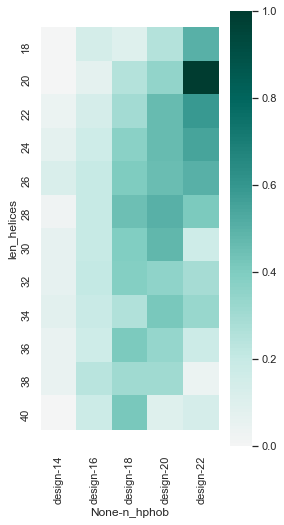

In [10]:
heatmap(term='design', df=summary)

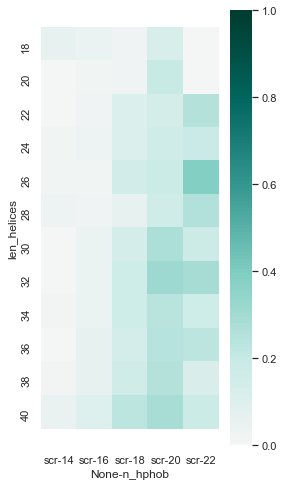

In [632]:
heatmap(term='scr', df=summary)

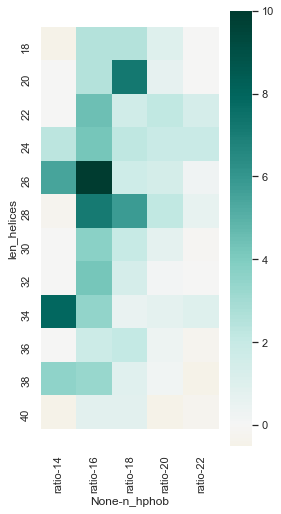

In [637]:
heatmap(term='ratio', df=summary)

### Fig S9

In [14]:
def middle_loop_information(df):
    ''' add len_L2 and residue_L2 info to df '''
    sec_structures = [  sec_str for sec_str in df['dssp'] ]
    sequences = [ seq for seq in df['sequence']]
    all_residues = []
    len_residues = []

    for structure, sequence in zip(sec_structures, sequences):
        loop2_start = structure.find('EL')+1 # find start position for the middle loop
        loop2_end = structure.find('LE', loop2_start)+1 # find end position for middle loop
        residues = sequence[loop2_start:loop2_end] # find residues for middle loop
        all_residues.append(residues)
        len_residues.append(len(residues))
    df['len_L2'] = len_residues
    df['res_L2'] = all_residues

    # there's 3795 designs with loop 2 length of 2; only 169 designs with length 3, and 30 designs with length 4
    # so focus on length 2 = 2
    sub_df = df.query('len_L2 == 2') 
    sub_df['hphob_1'] = [ 1 if res in 'AFILMWVY' else 0 for res in sub_df['res_L2'].str[0]]
    sub_df['hphob_2'] = [ 2 if res in 'AFILMWVY' else 0 for res in sub_df['res_L2'].str[1]]
    sub_df['hphob_1_2'] = [ hphob_1+hphob_2 for hphob_1, hphob_2 in zip(sub_df['hphob_1'], sub_df['hphob_2']) ]

    # there's only 23 designs whose hphob value is 3 which is both loop positions are hphob, so filter those out
    sub_df = sub_df.query('hphob_1_2 !=3')
    return sub_df

loop_2 = middle_loop_information(df=filtered_rd6)

<ipython-input-14-d404d5ab1776>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['len_L2'] = len_residues
<ipython-input-14-d404d5ab1776>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['res_L2'] = all_residues
<ipython-input-14-d404d5ab1776>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html

(KstestResult(statistic=0.031205396855679364, pvalue=0.4544120447902277),
 KstestResult(statistic=0.13594629205634678, pvalue=8.695756448240388e-09),
 KstestResult(statistic=0.11649950118535524, pvalue=5.885802147220787e-06))

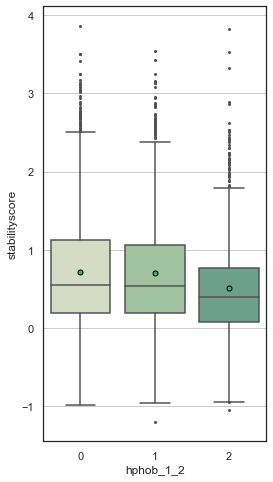

In [19]:
def boxplot_middle_loop(df):
   # plt.rcParams['axes.axisbelow'] = True
    plt.grid(axis = 'y', zorder=-1)
    flierprops = dict(marker='o', markersize=2)
    colors=sns.cubehelix_palette(start=.5, rot=-.75,)# as_cmap=True)

    sns.boxplot(x='hphob_1_2', y='stabilityscore', data=df,
                palette=colors, flierprops=flierprops, zorder=10,
                showmeans=True,
                meanprops={'marker':'o', 'markeredgecolor':'black', 'markersize':5})

    # ks2 sample test
    zero = df.query('hphob_1_2 == 0') # no hphob residue
    one = df.query('hphob_1_2 == 1') # 1 hphob residue near N-term
    two = df.query('hphob_1_2 == 2') # 1 hphob residue near C-term
    three = df.query('hphob_1_2 == 3') # hphob on both residues
    
    ks_01 = ks_2samp(zero['stabilityscore'], one['stabilityscore'], )
    ks_02 = ks_2samp(zero['stabilityscore'], two['stabilityscore'], )
    ks_12 = ks_2samp(one['stabilityscore'], two['stabilityscore'], )
    
    #plt.savefig('FgiS8.svg')
    return ks_01, ks_02, ks_12

boxplot_middle_loop(df=loop_2)

In [168]:
loop_bootstrap=pd.read_csv('../data/analysis/rd6_loop_constriction_bootstrap.csv')

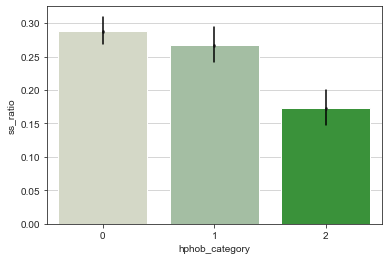

In [190]:
def plot_average_stability(df):

    # keep 95% conf int
    conf_int = 0.95
    margin = (1-conf_int)/2*1000
    upper = (1000-margin)
    lower = margin

    conf_int_df = pd.DataFrame()
    for hphob_cat in range(3):
        sub = df.query('hphob_category == @hphob_cat').sort_values(by = 'ss_ratio').reset_index().loc[lower:upper+1]
        conf_int_df = pd.concat([conf_int_df, sub])

    for i in range(3):
        ratio_min = min(conf_int_df.query('hphob_category==@i')['ss_ratio'])
        ratio_max = max(conf_int_df.query('hphob_category==@i')['ss_ratio'])
        plt.plot( [i, i], [ratio_min, ratio_max], color='black', zorder=10)
    plt.grid(axis='y')
    sns.barplot(x='hphob_category', y='ss_ratio', data=df, palette=['#D5DBC4', '#A0C29F','#2CA02C', '#4F7881'])

    #plt.savefig('FigS8b.svg')
    
plot_average_stability(df=loop_bootstrap)




### Fig S10 abego list 

### Fig S11

In [7]:
# load data
rd5_af = pd.read_csv('../data/design_structural_metrics/rd5_alphafold.csv') 
rd6_af = pd.read_csv('../data/design_structural_metrics/rd6_alphafold.csv') 

# add stability score data
rd5_af=pd.merge(left=rd5_af, right=rd5_scores[['name', 'stabilityscore']], on='name', how='inner')
rd6_af=pd.merge(left=rd6_af, right=rd6_scores[['name', 'stabilityscore']], on='name', how='inner')

# add Rosetta design model's total score
rd5_af=pd.merge(left=rd5_af, right=rd5_metrics[['name', 'total_score']], on='name', how='inner')

rd6_metrics=pd.read_csv('../data/design_structural_metrics/rd6_metrics_filtered.csv')
rd6_af=pd.merge(left=rd6_af, right=rd6_metrics[['name', 'total_score']], on='name', how='inner')


A:  -0.2900574447998362
B:  -0.01217292148145348
C:  -0.24266226010971553
D:  -0.09421241345843967
E:  0.4441726697642012
F:  0.4388818433178879
G:  -0.07500515797373825
H:  -0.05562592864095441


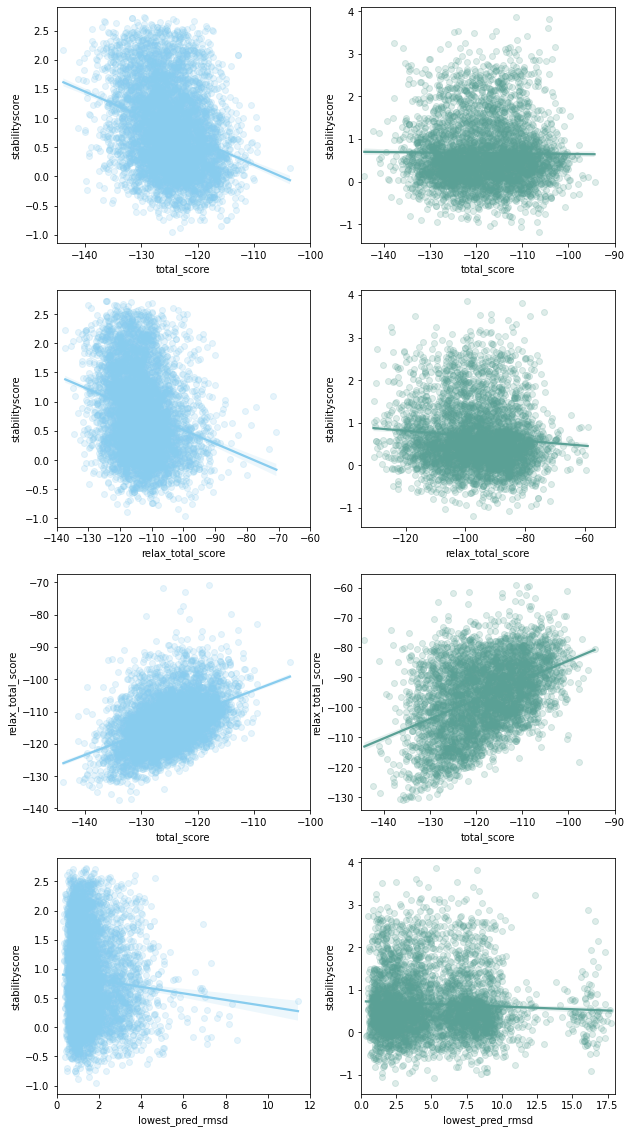

In [8]:
def plot_af(df, df2):
    
    plt.figure(figsize=(10, 20))

    plt.subplot(4, 2, 1)
    sns.regplot(x='total_score', y='stabilityscore', data=df, scatter_kws={'alpha':0.2}, color='#88CCEE')
    plt.xlim(-145, -100)
    print('A: ', np.corrcoef(df['total_score'], df['stabilityscore'])[0][1])

    plt.subplot(4, 2, 2)
    sns.regplot(x='total_score', y='stabilityscore', data=df2, scatter_kws={'alpha':0.2}, color='#5AA095')
    plt.xlim(-145, -90)
    print('B: ', np.corrcoef(df2['total_score'], df2['stabilityscore'])[0][1])    
    
    
    plt.subplot(4, 2, 3)
    sns.regplot(x='relax_total_score', y='stabilityscore', data=df, scatter_kws={'alpha':0.2}, color='#88CCEE')
    plt.xlim(-140, -60)
    print('C: ', np.corrcoef(df['relax_total_score'], df['stabilityscore'])[0][1])
    
    plt.subplot(4, 2, 4)
    sns.regplot(x='relax_total_score', y='stabilityscore', data=df2, scatter_kws={'alpha':0.2}, color='#5AA095')
    plt.xlim(-135, -50)
    print('D: ', np.corrcoef(df2['relax_total_score'], df2['stabilityscore'])[0][1])    
    
    
    plt.subplot(4, 2, 5)
    sns.regplot(x='total_score', y='relax_total_score', data=df, scatter_kws={'alpha':0.2}, color='#88CCEE')
    plt.xlim(-145, -100)
    print('E: ', np.corrcoef(df['total_score'], df['relax_total_score'])[0][1])
    
    plt.subplot(4, 2, 6)
    sns.regplot(x='total_score', y='relax_total_score', data=df2, scatter_kws={'alpha':0.2}, color='#5AA095')
    plt.xlim(-145, -90)
    print('F: ', np.corrcoef(df2['total_score'], df2['relax_total_score'])[0][1])


    plt.subplot(4, 2, 7)
    sns.regplot(x='lowest_pred_rmsd', y='stabilityscore', data=df, scatter_kws={'alpha':0.2}, color='#88CCEE')
    plt.xlim(0, 12)
    print('G: ', np.corrcoef(df['lowest_pred_rmsd'], df['stabilityscore'])[0][1])
    
    plt.subplot(4, 2, 8)
    sns.regplot(x='lowest_pred_rmsd', y='stabilityscore', data=df2, scatter_kws={'alpha':0.2}, color='#5AA095')
    plt.xlim(0, 18)
    print('H: ', np.corrcoef(df2['lowest_pred_rmsd'], df2['stabilityscore'])[0][1])
    
    #plt.savefig('FigS10.tiff', dpi=500)
plot_af(df=rd5_af, df2=rd6_af)

0.6464272657871252 0.6354193547519973 0.5361017252131651 0.4638982747868349
0.5178085894747946 0.5671469731133879 0.5302751295541754 0.4697248704458246


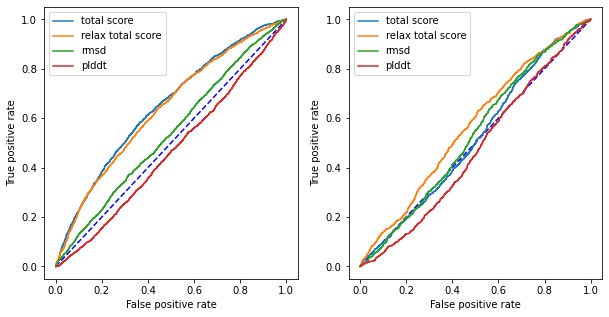

In [13]:
def roc_curves(df1, df2):
    
    data = [df1, df2]
    
    plt.figure(figsize=(10, 5))
    for df, i in zip(data, range(2)):
        # 1 if stability score >1, 0 if stability score < -1
        y_true = np.array([ 1 if ss>1 else 0 for ss in df['stabilityscore']])

        # Rosetta score or pLDDT 
        y_total_score = np.array([total_score for total_score in df['total_score']])
        y_relax_total_score = np.array([score for score in df['relax_total_score']])
        y_rmsd = np.array([score for score in df['lowest_pred_rmsd']])
        y_plddt = np.array([score for score in df['lowest_pred_rmsd']])

        # negative Rosetta score is more stable
        y_total_score = -y_total_score
        y_relax_total_score = -y_relax_total_score
        y_rmsd = -y_rmsd
      
        # auc
        auc = roc_auc_score(y_true, y_total_score)
        auc2 = roc_auc_score(y_true, y_relax_total_score)
        auc3 = roc_auc_score(y_true, y_rmsd)
        auc4 = roc_auc_score(y_true, y_plddt)
        print(auc, auc2, auc3, auc4)
    
        fpr, tpr, thresholds = roc_curve(y_true, y_total_score)
        fpr2, tpr2, thresholds2 = roc_curve(y_true, y_relax_total_score)
        fpr3, tpr3, thresholds3 = roc_curve(y_true, y_rmsd)
        fpr4, tpr4, thresholds4 = roc_curve(y_true, y_plddt)
       
        plt.subplot(1, 2, i+1)
        plt.plot([0, 1], [0, 1],'b--')
        plt.plot(fpr, tpr, label="total score")
        plt.plot(fpr2, tpr2, label="relax total score")
        plt.plot(fpr3, tpr3, label='rmsd')
        plt.plot(fpr4, tpr4, label='plddt')

        plt.legend()
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.savefig('FigS10_roc'+str(i+1)+'.svg')
roc_curves(df1=rd5_af, df2=rd6_af)

### Fig S12

In [9]:
rd5_af['diff_score'] = rd5_af['relax_total_score']-rd5_af['total_score']
rd6_af['diff_score'] = rd6_af['relax_total_score']-rd6_af['total_score']


In [22]:
def plot_af_rmsd_subsets(df, df2, xvalue):
    
    plt.figure(figsize=(12, 20))
    
    plt.subplot(5, 2, 1)
    sns.kdeplot(df.query('stabilityscore <=0')[xvalue],  color='gray')
    sns.kdeplot(df.query('stabilityscore >0 & stabilityscore <=1')[xvalue], color='#88AEEE')
    sns.kdeplot(df.query('stabilityscore >1')[xvalue], color='#2B3990')


    plt.subplot(5, 2, 2)
    sns.kdeplot(df2.query('stabilityscore <=0')[xvalue],  color='gray')
    sns.kdeplot(df2.query('stabilityscore >0 & stabilityscore <=1')[xvalue], color='#8CA095')
    sns.kdeplot(df2.query('stabilityscore >1')[xvalue],  color='#5AA095')
    #plt.savefig('af_subset_'+xvalue+'.svg')



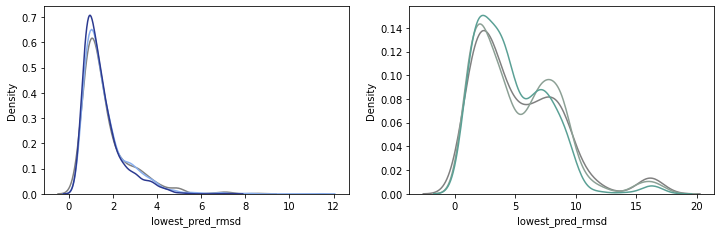

In [20]:
plot_af_rmsd_subsets(df=rd5_af, df2=rd6_af, xvalue='lowest_pred_rmsd')

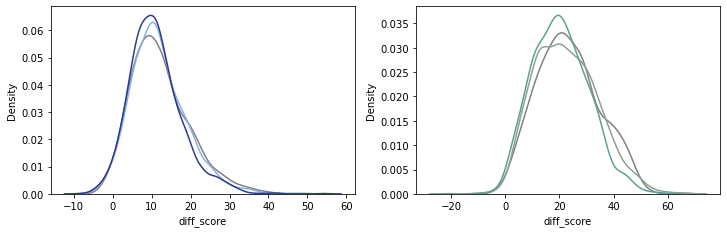

In [23]:

plot_af_rmsd_subsets(df=rd5_af, df2=rd6_af, xvalue='diff_score')


In [ ]:
def plot_af_rmsd_subsets(df, df2):
    
    plt.figure(figsize=(12, 20))
    
    plt.subplot(5, 2, 1)
    sns.kdeplot(df.query('stabilityscore <=0')['lowest_pred_rmsd'],  color='gray')
    sns.kdeplot(df.query('stabilityscore >0 & stabilityscore <=1')['lowest_pred_rmsd'], color='#88AEEE')
    sns.kdeplot(df.query('stabilityscore >1')['lowest_pred_rmsd'], color='#2B3990')


    plt.subplot(5, 2, 2)
    sns.kdeplot(df2.query('stabilityscore <=0')['lowest_pred_rmsd'],  color='gray')
    sns.kdeplot(df2.query('stabilityscore >0 & stabilityscore <=1')['lowest_pred_rmsd'], color='#8CA095')
    sns.kdeplot(df2.query('stabilityscore >1')['lowest_pred_rmsd'],  color='#5AA095')
    #plt.savefig('af_diffscore_rmsd_subset.svg')

plot_af_rmsd_subsets(df=rd5_af, df2=rd6_af)

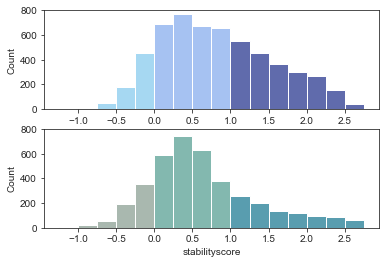

In [333]:
def histplot_scores_subset(df, df2):

    
    plt.subplot(2,1,1)
    sns.histplot(df.query('stabilityscore <=0')['stabilityscore'], bins=np.arange(-1.25, 3, 0.25), color='#88CCEE')
    sns.histplot(df.query('stabilityscore >0 & stabilityscore <=1')['stabilityscore'],  bins=np.arange(-1.25, 3, 0.25), color='#88AEEE')
    sns.histplot(df.query('stabilityscore >1')['stabilityscore'], bins=np.arange(-1.25, 3, 0.25), color='#2B3990')
    plt.ylim(0, 800)
    
    plt.subplot(2,1,2)
    sns.histplot(df2.query('stabilityscore <=0')['stabilityscore'], bins=np.arange(-1.25, 3, 0.25), color='#8CA095')
    sns.histplot(df2.query('stabilityscore >0 & stabilityscore <=1')['stabilityscore'],  bins=np.arange(-1.25, 3, 0.25), color='#5AA095')
    sns.histplot(df2.query('stabilityscore >1')['stabilityscore'], bins=np.arange(-1.25, 3, 0.25), color='#227D95')
    plt.ylim(0, 800)
    plt.savefig('figS11_scores_subset.svg')
    
histplot_scores_subset(df=rd5, df2=filtered_rd6)

In [50]:
def ratio_less_than_2angstrom(df, threshold):
    less_2 = len(df.query('lowest_pred_rmsd <= @threshold'))
    n = len(df)
    ratio = less_2 / n
    
    less_0 = len(df.query('lowest_pred_rmsd <= @threshold & stabilityscore <= 0'))
    total_less_0 = len(df.query('stabilityscore <= 0'))
    
    middle = len(df.query('lowest_pred_rmsd <= @threshold & stabilityscore > 0 & stabilityscore <= 1'))
    total_middle = len(df.query('stabilityscore > 0 & stabilityscore <= 1'))
    
    greater_1 = len(df.query('lowest_pred_rmsd <= @threshold & stabilityscore > 1'))
    total_greater_1 = len(df.query('stabilityscore > 1'))
#    x_axis = ['less_than_2', 'greater_than)2']
#    y_axis = [ratio, 1-ratio]
    #sns.barplot(x=x_axis, y=y_axis)
    print('total: ', ratio)
    print('<0: ', less_0/total_less_0 )
    print('>0 & <=1: ', middle/total_middle)
    print('>1: ', greater_1/total_greater_1 )


In [51]:
ratio_less_than_2angstrom(df=rd5_af, threshold=2)

total:  0.7755428978284087
<0:  0.7528735632183908
>0 & <=1:  0.7582614942528736
>1:  0.8054256314312441


In [52]:
ratio_less_than_2angstrom(df=rd6_af, threshold=2)

total:  0.19654481722583875
<0:  0.19298245614035087
>0 & <=1:  0.20025564550489988
>1:  0.19019607843137254


In [33]:
z=rd5_af.query('lowest_pred_rmsd <=2 & stabilityscore > 1')
len(z)/len(rd5_af.query('stabilityscore > 1'))

0.8054256314312441